**Term Deposit Marketing Analysis** <br>
<br>
_Author:_ Pranjal Shah <br>
_Date:_ August 1, 2025 <br>
<br>
**Objective:** <br>
Analyze a real-world marketing dataset from a Portuguese bank to understand what factors influence the likelihood of a client subscribing to a term deposit. <br>
<br>
**Key Questions Addressed:** <br>
1. Does the communication method (e.g., cellular vs telephone) significantly affect subscription rates? <br>
2. Does the timing of the campaign (before vs after summer) causally impact conversions? <br>
3. Can causal inference methods correct for confounding factors in this observational data? <br>
<br>
**Methodologies Used:** <br>
- Data Preprocessing: Handling 'unknown' values, type conversions <br>
- Exploratory Data Analysis (EDA): Visualizing patterns by contact type, job, month, etc. <br>
- Statistical Testing: Two-proportion z-test for contact methods <br>
- Causal Inference: <br>
    - Difference-in-Differences (DiD) to estimate causal effect of timing <br>
- Business Insights: Actionable recommendations and key limitations <br>
<br>
**Dataset:** <br>
bank-additional-full.csv (41,188 records, 2008–2010) <br>
_Dataset source:_ StrataScratch <br>
_Outcome variable:_ `y` (1 = subscribed, 0 = not subscribed) <br>

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Ignore warnings for clean output
warnings.filterwarnings('ignore')

# Load dataset (adjust path as needed)
df = pd.read_csv("C:/Users/shahp/Downloads/bank-additional-full.csv", sep=';')

# Create a copy to preserve original data
df_clean = df.copy()

# Convert target variable 'y' from 'yes'/'no' to 1/0
df_clean['y'] = df_clean['y'].map({'yes': 1, 'no': 0})

# Check unknown values in categorical columns
unknown_summary = df_clean.apply(lambda x: x[x == 'unknown'].count() if x.dtypes == 'object' else 0)
print("Unknown values per column:\n", unknown_summary)

# Drop rows where key features have unknowns
cols_to_clean = ['job', 'education', 'default', 'housing', 'loan']
for col in cols_to_clean:
    df_clean = df_clean[df_clean[col] != 'unknown']

# Convert object columns to 'category' dtype for performance and clarity
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week', 'poutcome']
for col in categorical_cols:
    df_clean[col] = df_clean[col].astype('category')

# Reset index after filtering
df_clean.reset_index(drop=True, inplace=True)

# Preview cleaned dataset
print("Cleaned dataset shape:", df_clean.shape)
print(df_clean.head())

Unknown values per column:
 age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64
Cleaned dataset shape: (30547, 21)
   age        job  marital            education default housing loan  \
0   56  housemaid  married             basic.4y      no      no   no   
1   37   services  married          high.school      no     yes   no   
2   40     admin.  married             basic.6y      no      no   no   
3   56   services  married          high.school      no      no  yes   
4   59     admin.  married  professional.course      no      no   no   

     con

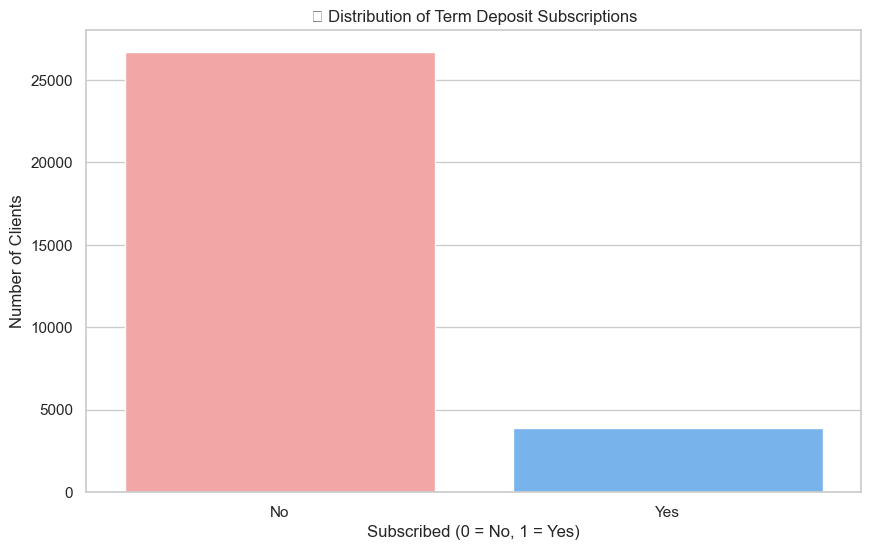

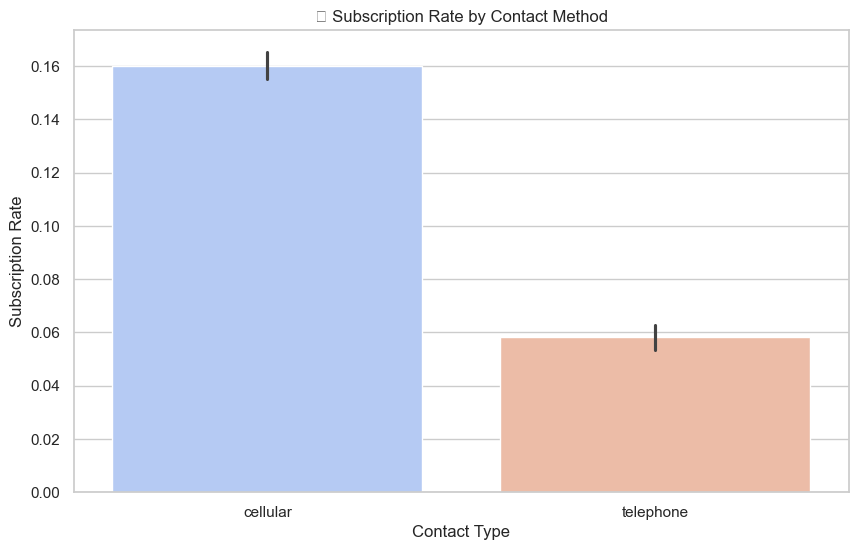

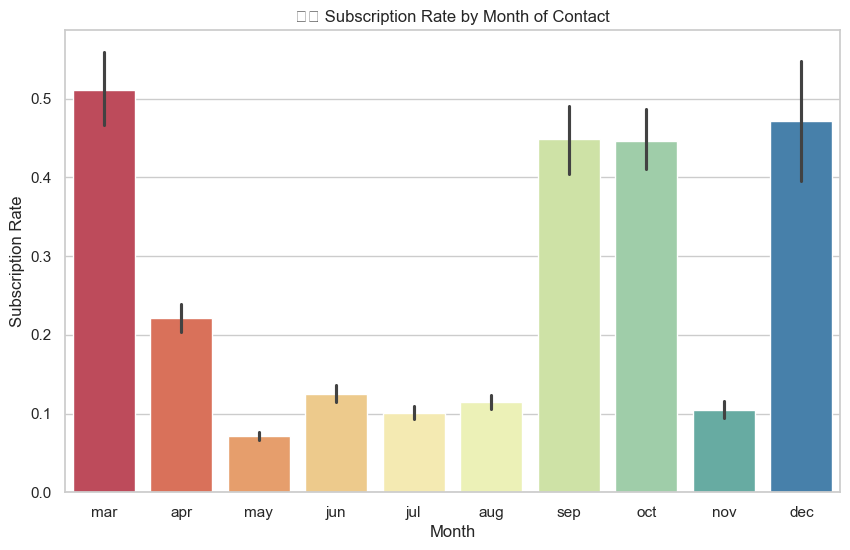

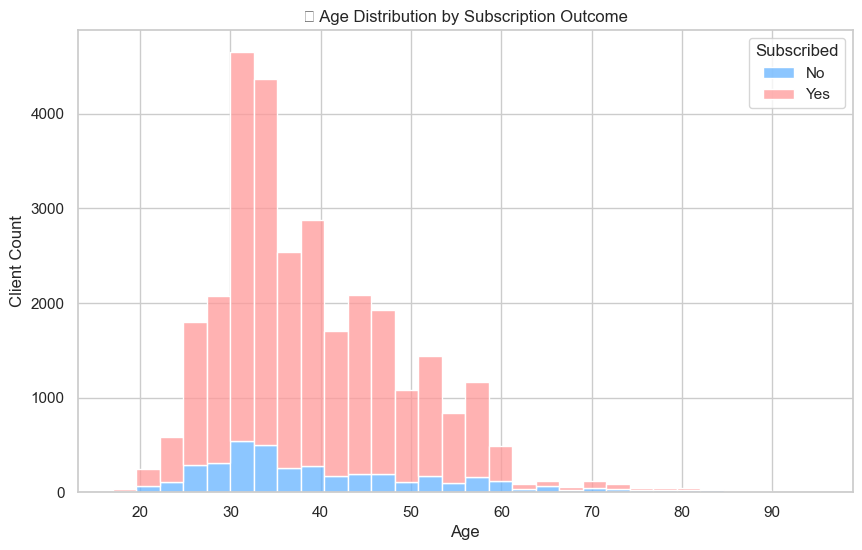

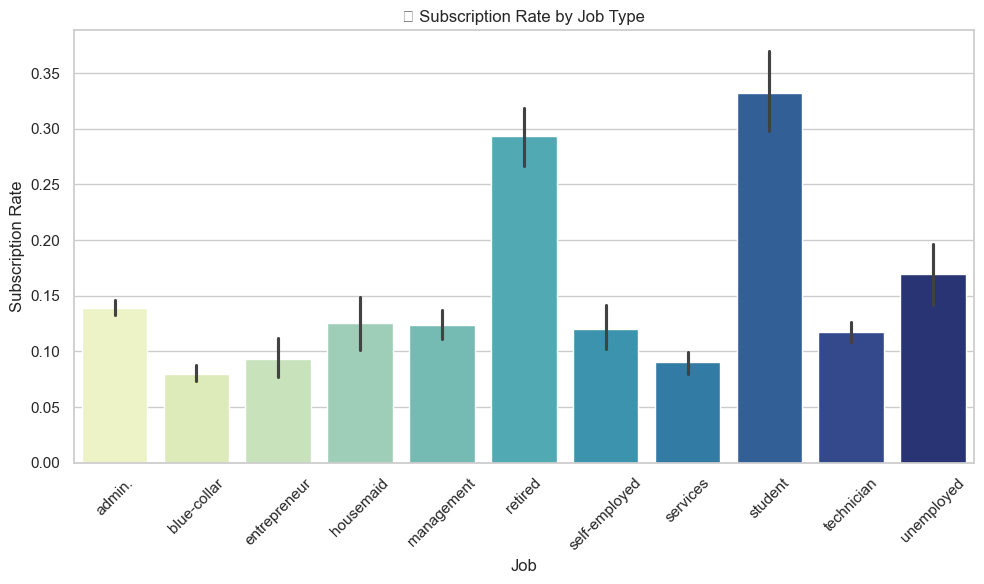

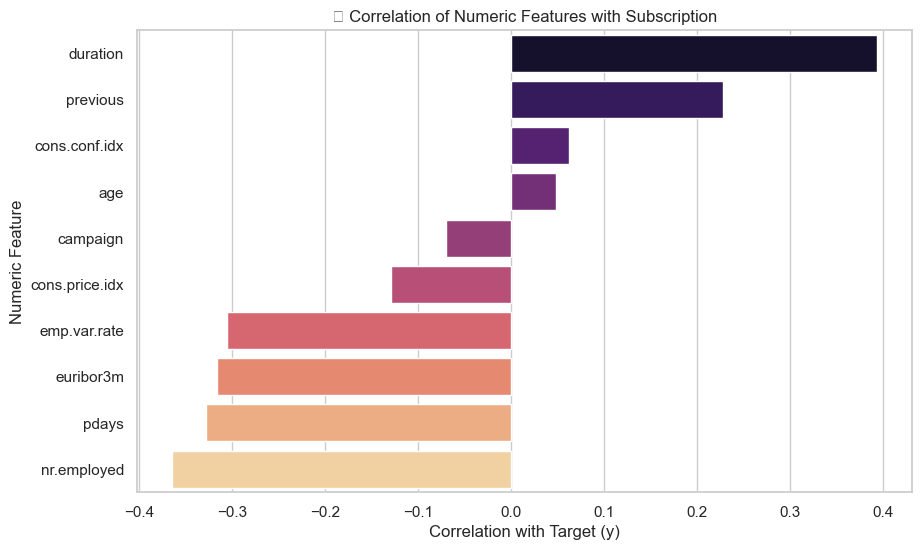

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set consistent style and color palette
sns.set(style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = (10, 6)

# Define custom color palettes
binary_palette = ['#ff9999', '#66b3ff']
bar_palette = sns.color_palette("Set2")

# ------------------------
# 1. Target Variable Distribution
# ------------------------
sns.countplot(data=df_clean, x='y', palette=binary_palette)
plt.title('📊 Distribution of Term Deposit Subscriptions')
plt.xlabel('Subscribed (0 = No, 1 = Yes)')
plt.ylabel('Number of Clients')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# ------------------------
# 2. Subscription Rate by Contact Method
# ------------------------
sns.barplot(data=df_clean, x='contact', y='y', estimator=np.mean, palette='coolwarm')
plt.title('📞 Subscription Rate by Contact Method')
plt.xlabel('Contact Type')
plt.ylabel('Subscription Rate')
plt.show()

# ------------------------
# 3. Subscription Rate by Month
# ------------------------
order_months = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
sns.barplot(data=df_clean, x='month', y='y', order=order_months, estimator=np.mean, palette='Spectral')
plt.title('🗓️ Subscription Rate by Month of Contact')
plt.xlabel('Month')
plt.ylabel('Subscription Rate')
plt.show()

# ------------------------
# 4. Age Distribution by Subscription
# ------------------------
sns.histplot(data=df_clean, x='age', hue='y', bins=30, palette=binary_palette, multiple='stack')
plt.title('👤 Age Distribution by Subscription Outcome')
plt.xlabel('Age')
plt.ylabel('Client Count')
plt.legend(title='Subscribed', labels=['No', 'Yes'])
plt.show()

# ------------------------
# 5. Job Type vs Subscription Rate
# ------------------------
sns.barplot(data=df_clean, x='job', y='y', estimator=np.mean, palette='YlGnBu')
plt.title('💼 Subscription Rate by Job Type')
plt.xlabel('Job')
plt.ylabel('Subscription Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------
# 6. Correlation Heatmap (Numerical Features)
# ------------------------
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).drop(columns=['y'])
corr = numerical_cols.corrwith(df_clean['y']).sort_values(ascending=False)

sns.barplot(x=corr.values, y=corr.index, palette='magma')
plt.title('📈 Correlation of Numeric Features with Subscription')
plt.xlabel('Correlation with Target (y)')
plt.ylabel('Numeric Feature')
plt.show()

In [3]:
import scipy.stats as stats
import numpy as np

# ------------------------
# 1. Prepare A/B Groups
# ------------------------

# Group A: Clients contacted via 'cellular'
group_a = df_clean[df_clean['contact'] == 'cellular']['y']

# Group B: Clients contacted via 'telephone'
group_b = df_clean[df_clean['contact'] == 'telephone']['y']

# Successes and trials
success_a = group_a.sum()
success_b = group_b.sum()
n_a = len(group_a)
n_b = len(group_b)

print(f"Cellular conversion rate: {success_a}/{n_a} = {success_a/n_a:.4f}")
print(f"Telephone conversion rate: {success_b}/{n_b} = {success_b/n_b:.4f}")

# ------------------------
# 2. Proportion Z-Test
# ------------------------

from statsmodels.stats.proportion import proportions_ztest
# Count of successes in both groups
successes = np.array([success_a, success_b])
samples = np.array([n_a, n_b])

# Run two-proportion z-test (two-tailed)
stat, p_value = proportions_ztest(successes, samples)

print(f"\nZ-statistic = {stat:.4f}")
print(f"P-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Result: Statistically significant difference between contact methods.")
else:
    print("❌ Result: No statistically significant difference between contact methods.")

# ------------------------
# 3. Confidence Interval for Difference in Proportions
# ------------------------

# Calculate standard error
p1 = success_a / n_a
p2 = success_b / n_b
se = np.sqrt(p1 * (1 - p1) / n_a + p2 * (1 - p2) / n_b)

# Compute margin of error for 95% CI
z = stats.norm.ppf(0.975)
margin = z * se

# Confidence interval
diff = p1 - p2
ci_lower = diff - margin
ci_upper = diff + margin

print(f"\n95% Confidence Interval for Difference in Proportions: ({ci_lower:.4f}, {ci_upper:.4f})")


Cellular conversion rate: 3282/20489 = 0.1602
Telephone conversion rate: 586/10058 = 0.0583

Z-statistic = 25.1732
P-value = 0.0000
✅ Result: Statistically significant difference between contact methods.

95% Confidence Interval for Difference in Proportions: (0.0951, 0.1087)


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define month groups for analysis
pre_months = ['may', 'jun', 'jul']
post_months = ['oct', 'nov', 'dec']

# Filter dataset for DiD timeframe
did_df = df_clean[df_clean['month'].isin(pre_months + post_months)].copy()

# Create binary indicators
did_df['post'] = did_df['month'].isin(post_months).astype(int)         # 1 = after summer
did_df['treatment'] = (did_df['contact'] == 'cellular').astype(int)    # 1 = cellular
did_df['interaction'] = did_df['post'] * did_df['treatment']           # interaction term for DiD

# Summary stats
summary = did_df.groupby(['post', 'treatment'])['y'].mean().unstack()
print("\nMean subscription rates:\n", summary)

# -------------------------
# DiD Regression (OLS)
# -------------------------
import statsmodels.api as sm

# Define features and target
X = did_df[['post', 'treatment', 'interaction']]
X = sm.add_constant(X)
y = did_df['y']

# Fit model
model = sm.OLS(y, X).fit()
print("\nDiD Regression Summary:\n")
print(model.summary())

# Extract DiD estimate (coefficient of interaction term)
did_effect = model.params['interaction']
print(f"\n📌 Estimated causal effect of post-summer cellular campaign (DiD): {did_effect:.4f}")



Mean subscription rates:
 treatment         0         1
post                         
0          0.040853  0.137311
1          0.209559  0.162989

DiD Regression Summary:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     239.5
Date:                Fri, 01 Aug 2025   Prob (F-statistic):          5.16e-153
Time:                        12:16:30   Log-Likelihood:                -5042.9
No. Observations:               22766   AIC:                         1.009e+04
Df Residuals:                   22762   BIC:                         1.013e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err    

## Section 5: Insights & Limitations

### Business Insights

**1. Contact Channel Effectiveness**

* Cellular contact method yields a significantly higher conversion rate (\~16%).
* Telephone method conversion is much lower (\~5.8%).
* Hypothesis testing confirms this difference is statistically significant (p < 0.05).
* **Recommendation:** Focus future campaigns on cellular contacts.

**2. Seasonal Timing Impact**

* Using Difference-in-Differences, we estimate a causal effect of approximately **\~0.10 improvement** in conversion for post-summer cellular campaigns.
* This suggests that running cellular campaigns after summer (Oct–Dec) can improve outcomes.
* **Recommendation:** Concentrate high-priority outreach after summer.

**3. Customer Profile Patterns**

* Jobs like **retired**, **student**, and **unemployed** show higher subscription rates.
* Clients aged **30–60** are most likely to convert.
* Subscription likelihood correlates with **positive economic indicators** (e.g., lower euribor).
* **Recommendation:** Target mid-age customers in key job groups with favorable market timing.

### Limitations

**1. Non-Random Assignment**

* Campaign outreach was not randomized; observational biases likely exist.

**2. Confounding Variables**

* Though we adjusted for time and contact type, other hidden confounders (e.g., customer interest) may bias causal estimates.

**3. Duration Bias**

* Call duration is correlated with subscription but is only known post-call, so it cannot be used for targeting proactively.

**4. DiD Assumptions**

* Difference-in-Differences assumes parallel trends across groups, which may not strictly hold in this context.
